# Developing scripts to test different connectivity schemes

In [2]:
import jax
import math
import jax.numpy as jnp
import optax
import flax
from flax import nnx
from flax.nnx.nn import initializers
from typing import Callable
import orbax.checkpoint as ocp
import json
import os
import pickle

# from PseudoMLP import PseudoMLP
from utils import clipping_ste

import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

import matplotlib.pyplot as plt
import seaborn as sns

2025-04-30 18:25:33.752710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746062733.766707 3658191 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746062733.770799 3658191 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# One-to-one connectivity

* Every core in layer $l-1$ connects exactly to one core in layer $l$.
* Cores in layer $l-1$ send their outputs in a chunkwise random manner to the cores in layer $l$
* Let $x_n (s) \in \mathbb{R}^{P}$ be a "chunk" of the output present at a given slot $s$
* Define a tensor $C \in \mathbb{\{-1, 0, +1\}}^{(i, j, s^{l-1}), (k, l, s^{l})}$ which says:
    * If the core in layer $l-1$ at index $(i, j)$ is connected to a core in layer $l$ at index $(k, l)$ and the slot $s^{l-1}$ is connected to slot $s^l$, then
    $$
    C[i,j,k,l,s^{l-1}, s^l] = 
    \begin{cases}
    -1, \quad x_n(s^{l}) \in x^-, \\
    +1, \quad x_n(s^{l}) \in x^+
    \end{cases}
    $$

(2, 4, 16, 16)


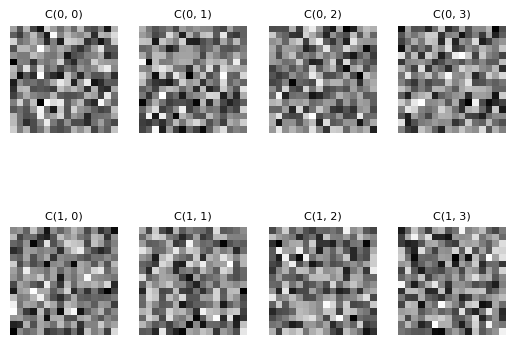

In [4]:
# weights on the cores
core_rows = 16
core_cols = 16
total_cores = 8
num_layers = 2
cores_per_layer = total_cores // num_layers

# initialize weights on all the cores
rngs = nnx.Rngs(params=1, activations=2, masks=3)
initializer = flax.nnx.nn.initializers.glorot_normal()
weights = initializer(rngs.params(), (num_layers, cores_per_layer, core_rows, core_cols))
print(weights.shape)

fig, ax = plt.subplots(weights.shape[0], weights.shape[1])

for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        ax[i, j].imshow(weights[i, j, ...], cmap='gray')
        ax[i, j].set_title(f"C{i, j}", fontsize = 8)
        ax[i, j].axis('off')

In [ ]:
# scrambling but keeping balance condition

class SimpleScramble(nnx.Module):
    def __init__(
        self,
        input_length: int,
        core_length: int,
        slot_length: int,
        avg_cores_per_chunk: int,
        rngs: nnx.Rngs,
    ):

    self.input_length = input_length
    self.core_length = core_length
    self.slot_length = slot_length
    self.avg_cores_per_chunk = avg_cores_per_chunk
    self.rngs = rngs
    
    self.

[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]


[57 47 40  2 30  9 60  5 44 25 56 45 55 37 43 29 19 17 36 49  8 13  3 61
 20 26  6 16  4 34 32 53 31 51  1 27 59 41 10 33 50 28 22 35 62 23 46 42
 11 63 48 21 14 12  0 52 58 39  7 24 54 18 15 38]
Corewise permutation
Slot-wise permutation
Scrambled inputs to slots
Copy of inputs to slots, scrambled
xpos - xneg


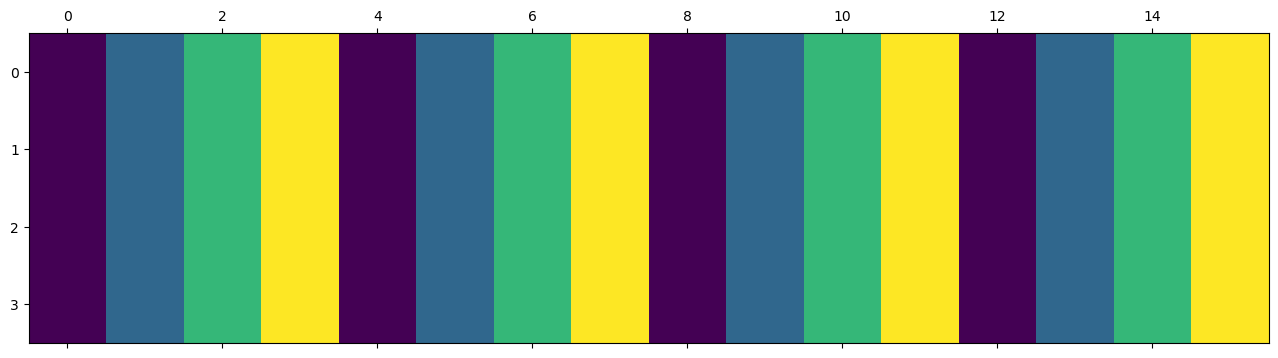

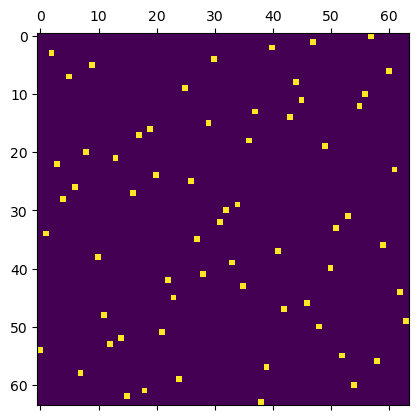

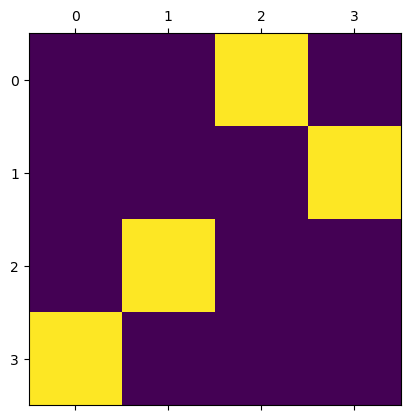

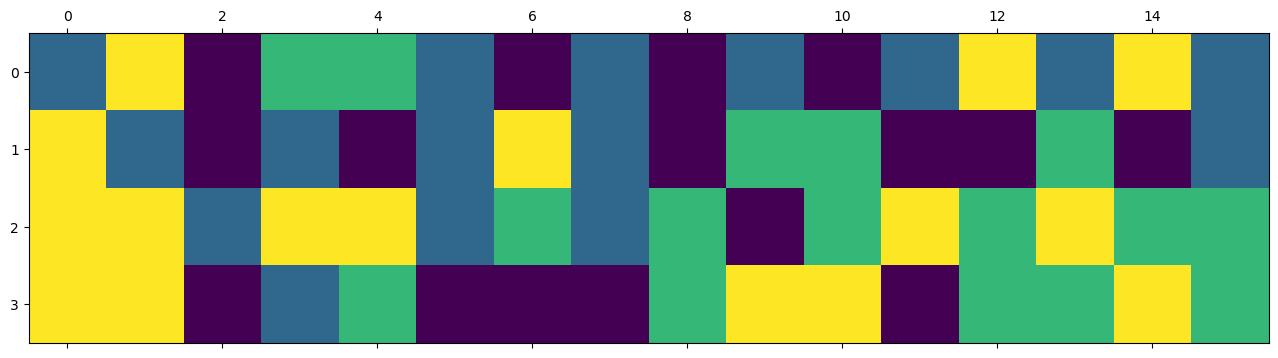

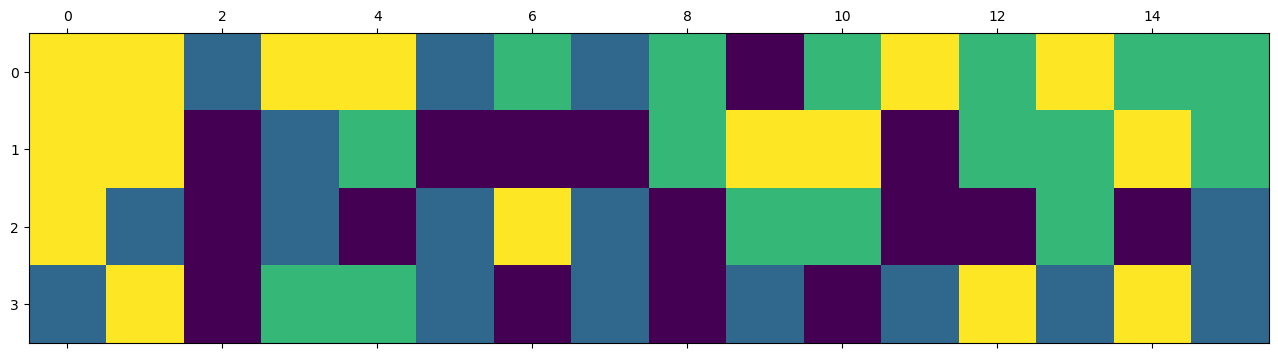

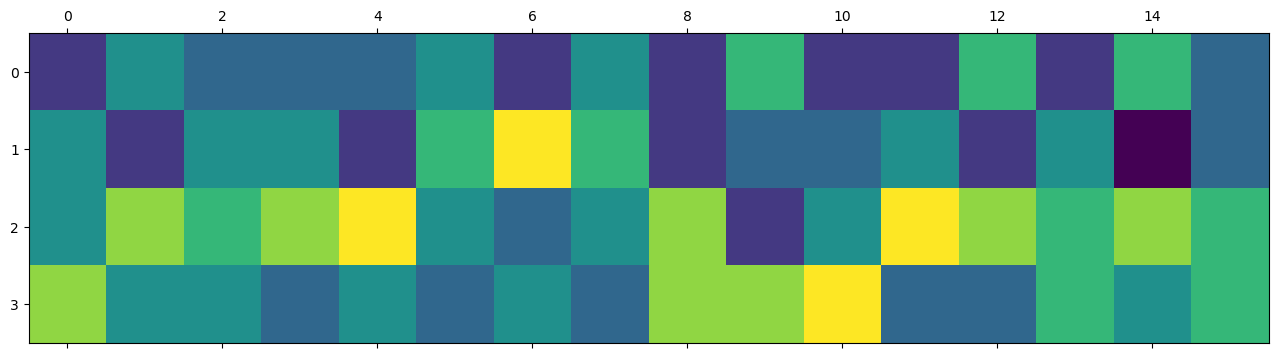

In [20]:
x_test = jnp.tile(jnp.array([0, 1, 2, 3]), 16)

plt.matshow(x_test.reshape(4, -1))

# makinf the core-wise permutation
p1 = jnp.eye(x_test.shape[0])
# plt.matshow(p1)
rand_perm = jax.random.permutation(rngs.params(), x_test.shape[0])
rand_perm_cores = jax.random.permutation(rngs.params(), 4)
p2 = jnp.eye(x_res.shape[0])
p2 = p2[rand_perm_cores]
print(rand_perm)
p1 = p1[rand_perm]
print(f"Corewise permutation")
plt.matshow(p1)
print(f"Slot-wise permutation")
plt.matshow(p2)

x_scr = jnp.einsum('ij,j->i', p1, x_test)
print(f"Scrambled inputs to slots")
plt.matshow(x_scr.reshape(4, -1))

x_res = x_scr.reshape(4, -1)
x_scr2 = jnp.einsum('ij,jk->ik', p2, x_res)
# x_scr2 = x_scr2.reshape(-1,)
print(f"Copy of inputs to slots, scrambled")
plt.matshow(x_scr2)

print(f"xpos - xneg")
plt.matshow((x_scr - x_scr2.flatten()).reshape(4, -1))

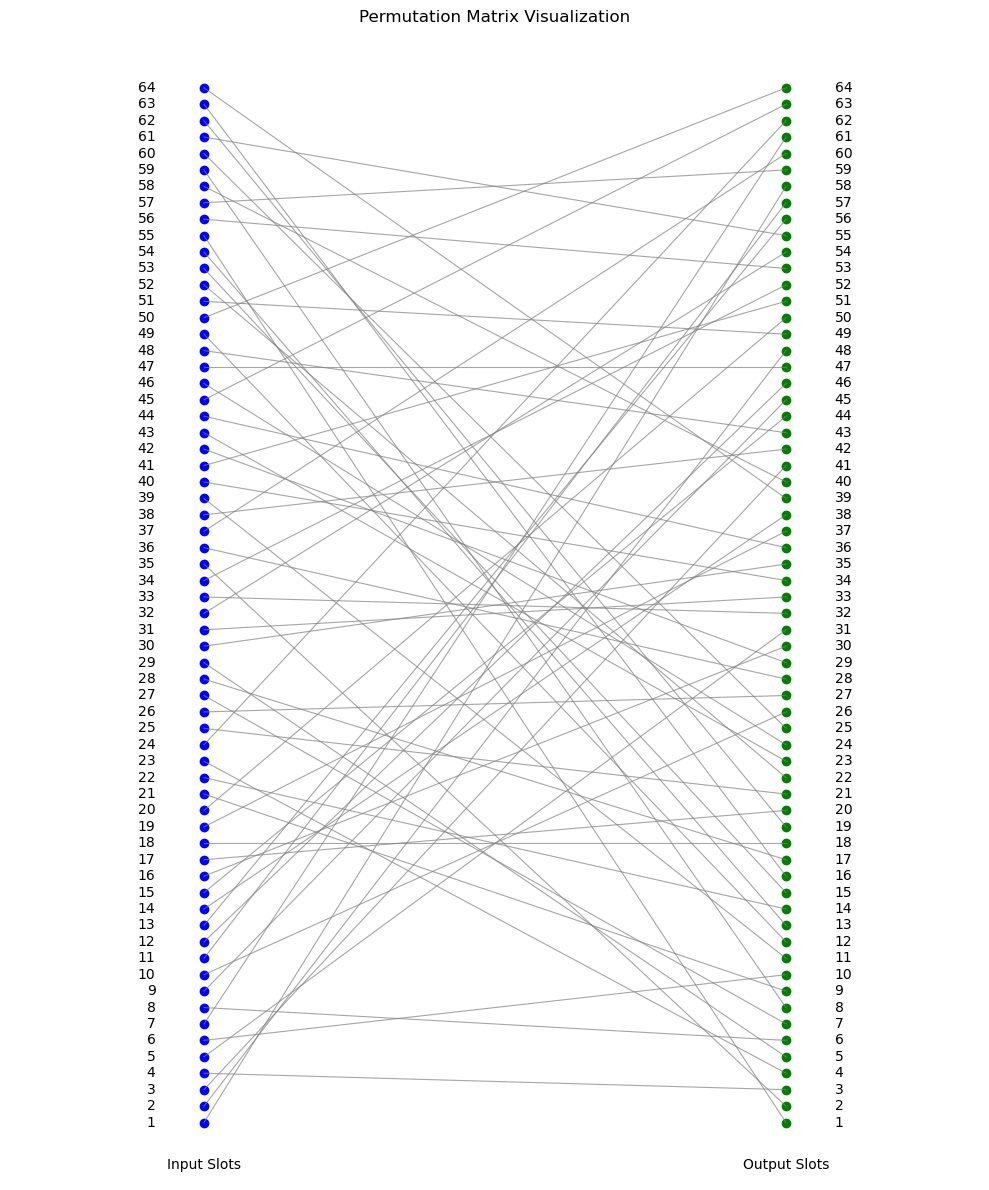

In [23]:
def visualize_permutation_matrix(P):
    """
    Visualize a permutation matrix as a bipartite graph.
    
    Parameters:
    -----------
    P : numpy.ndarray
        A permutation matrix (n x n) with entries of 0s and 1s
    """
    n = P.shape[0]  # Size of the permutation matrix (assuming square)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 12))
    
    # Set positions for left and right columns of dots
    left_x = 0.2
    right_x = 0.8
    y_positions = jnp.linspace(0.05, 0.95, n)
    
    # Plot dots for left column (input slots)
    left_points = []
    for i in range(n):
        left_points.append((left_x, y_positions[i]))
        ax.plot(left_x, y_positions[i], 'o', color='blue', markersize=6)
        ax.text(left_x - 0.05, y_positions[i], f"{i+1}", ha='right', va='center')
    
    # Plot dots for right column (output slots)
    right_points = []
    for i in range(n):
        right_points.append((right_x, y_positions[i]))
        ax.plot(right_x, y_positions[i], 'o', color='green', markersize=6)
        ax.text(right_x + 0.05, y_positions[i], f"{i+1}", ha='left', va='center')
    
    # Draw lines based on the permutation matrix
    for i in range(n):
        j = jnp.where(P[i] == 1)[0][0]  # Find the position of 1 in row i
        ax.plot([left_x, right_x], [y_positions[i], y_positions[j]], 
                '-', color='gray', alpha=0.7, linewidth=0.8)
    
    # Set plot limits and remove axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    # Add title and labels
    plt.title('Permutation Matrix Visualization')
    plt.text(left_x, 0.01, 'Input Slots', ha='center')
    plt.text(right_x, 0.01, 'Output Slots', ha='center')
    
    plt.tight_layout()
    return fig

fig = visualize_permutation_matrix(p1)
plt.show()